For my project, I created a neural network that can identify a dog breed from a photo of a dog. I used the dataset from https://www.kaggle.com/competitions/dog-breed-identification/overview.

In [ ]:
competition_name = "dog-breed-identification"

from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "/content/drive/MyDrive/Colab Notebooks/kaggle.json"

! pip install kaggle --quiet

! mkdir ~/.kaggle
! cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c {competition_name}

! mkdir kaggle_data
! unzip {competition_name + ".zip"} -d kaggle_data

drive.flush_and_unmount()

Pre-Processing and Exploratory Data Analysis

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np

os.walk("/content/kaggle_data/test")

for dirpath, dirnames, filenames in os.walk("/content/kaggle_data"): # Looking at the directory structure.
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 2 images in '/content/kaggle_data'.
There are 0 directories and 10357 images in '/content/kaggle_data/test'.
There are 0 directories and 10222 images in '/content/kaggle_data/train'.


In [6]:
def view_random_image(target_dir):
  # Set up the target directory
  target_folder = target_dir

  # Find a random image
  random_image = random.sample(os.listdir(target_folder), 1)

  # Plot the image using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.axis("off");
  print(img.shape)

  return(img)


In [7]:
random_image = random.sample(os.listdir("/content/kaggle_data/train"), 1)

In [8]:
img = mpimg.imread("/content/kaggle_data/train" + "/" + random_image[0])

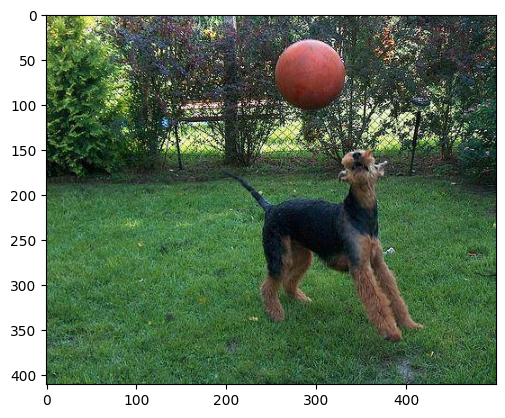

In [9]:
plt.imshow(img)

(230, 155, 3)


array([[[104, 126,  77],
        [ 75,  89,  40],
        [ 71,  66,  24],
        ...,
        [ 80, 111,  41],
        [ 85, 116,  46],
        [ 91, 120,  53]],

       [[116, 145,  97],
        [ 82, 101,  56],
        [ 66,  68,  28],
        ...,
        [ 80, 107,  38],
        [ 84, 111,  42],
        [ 90, 115,  49]],

       [[ 98, 141,  98],
        [ 73, 108,  66],
        [ 66,  82,  45],
        ...,
        [104, 125,  58],
        [107, 128,  61],
        [112, 131,  67]],

       ...,

       [[ 76,  83,  42],
        [ 61,  68,  26],
        [ 58,  67,  24],
        ...,
        [166, 168, 118],
        [166, 166, 114],
        [167, 164, 113]],

       [[127, 134,  93],
        [ 88,  95,  53],
        [ 56,  65,  22],
        ...,
        [112, 114,  67],
        [108, 107,  59],
        [102,  98,  51]],

       [[221, 228, 187],
        [157, 164, 122],
        [ 92, 101,  58],
        ...,
        [107, 108,  64],
        [101, 100,  54],
        [ 94,  90,  43]]

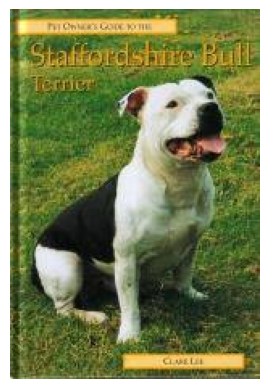

In [10]:
view_random_image("/content/kaggle_data/train")

In [12]:
import pandas as pd

In [13]:
df_labels = pd.read_csv("/content/kaggle_data/labels.csv")

In [14]:
df_labels # I view how the labels file looks. It includes each dog ID and the breed for the training data.

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

In [15]:
df_labels["id"] = df_labels["id"] + ".jpg" # Labels do not have the .jpg at the end of names so I add it.

In [16]:
df_labels

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07.jpg               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97.jpg                     dingo
2      001cdf01b096e06d78e9e5112d419397.jpg                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d.jpg                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62.jpg          golden_retriever
...                                     ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0.jpg                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f.jpg            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f.jpg                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac.jpg        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae.jpg  chesapeake_bay_retriever

[10222 rows x 2 columns]

I set up my images using an Image DataGenerator. First, I rescale pixels (divide by 255). I use data augmentation to adjust my training photos with rotation, shifts, zoom, horizontal flips, and brightness adjustments. I use an output image shape of (224, 224) since that is the standard and the training photos are in different dimensions. I also split up my training data into a train set and a test set using validation_split. For my inflow of data, I use "flow from dataframe" since the structure of the data is one that all photos are in a folder and a seperate dataframe label file identifies the breeds.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/kaggle_data/train/"


train_datagen = ImageDataGenerator(rescale=1/255.,
                                   validation_split = 0.2,
                                   rotation_range=10, # rotation
                                   width_shift_range=0.2, # horizontal shift
                                   height_shift_range=0.2, # vertical shift
                                   zoom_range=0.2, # zoom
                                   horizontal_flip=True, # horizontal flip randomly
                                   brightness_range=[0.2,1.2]) # brightness adjustment



print("Training images:")
train_data = train_datagen.flow_from_dataframe(dataframe = df_labels,
                                               directory = train_dir,
                                               x_col = "id",
                                               y_col = "breed",
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical",
                                               subset = "training")

print("Testing images:")
validation_data = train_datagen.flow_from_dataframe(dataframe = df_labels,
                                              directory = train_dir,
                                              x_col = "id",
                                              y_col = "breed",
                                              target_size=IMAGE_SHAPE,
                                              class_mode="categorical",
                                              subset = "validation")

Training images:
Found 8178 validated image filenames belonging to 120 classes.
Testing images:
Found 2044 validated image filenames belonging to 120 classes.


I also set up data that is the same as above, but not augmented, for testing purposes. I end "noaug" at the end to show this.

In [18]:
train_datagen_noaug = ImageDataGenerator(rescale=1/255.,
                                   validation_split = 0.2)

train_data_noaug = train_datagen.flow_from_dataframe(dataframe = df_labels,
                                               directory = train_dir,
                                               x_col = "id",
                                               y_col = "breed",
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical",
                                               subset = "training")

print("Testing images:")
validation_data_noaug = train_datagen.flow_from_dataframe(dataframe = df_labels,
                                              directory = train_dir,
                                              x_col = "id",
                                              y_col = "breed",
                                              target_size=IMAGE_SHAPE,
                                              class_mode="categorical",
                                              subset = "validation")

Found 8178 validated image filenames belonging to 120 classes.
Testing images:
Found 2044 validated image filenames belonging to 120 classes.


In [19]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

The first 2 pre-trained models that I use are Resnet 50 V2 and Efficient Net B0.

In [20]:
#Resnet 50 V2 model
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

#EfficientNetB0 model
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [21]:
# Since I will be making several models, I create a function.
def create_model(model_url, num_classes=10):

  # Download the pretrained model and save it as a layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create my own model adding an output layer with num_classes that will be the number of dog breeds (120).
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [22]:
 len(train_data.class_indices)

120

In [23]:
resnet_model = create_model(resnet_url, num_classes= len(train_data.class_indices)) # num_classes = 120

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

I use an early stoppage mechanism to prevent over-fitting. I use a patience of 3 to monitor if val_loss doesn't improve for 3 epochs.

In [162]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 120)               245880    
                                                                 
Total params: 23,810,680
Trainable params: 245,880
Non-trainable params: 23,564,800
_________________________________________________________________


In [24]:
from keras.callbacks import EarlyStopping

In [25]:
early_stoppage = EarlyStopping(monitor="val_loss", patience=3)

In [26]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=100,
                                  steps_per_epoch=len(train_data),
                                  validation_data=validation_data,
                                  validation_steps=len(validation_data),
                                  callbacks = [early_stoppage],
                                  )


Epoch 1/100
256/256 [==============================] - 153s 539ms/step - loss: 2.0083 - accuracy: 0.5056 - val_loss: 1.3458 - val_accuracy: 0.6169
Epoch 2/100
256/256 [==============================] - 137s 537ms/step - loss: 1.0020 - accuracy: 0.7085 - val_loss: 1.2786 - val_accuracy: 0.6438
Epoch 3/100
256/256 [==============================] - 132s 517ms/step - loss: 0.7801 - accuracy: 0.7682 - val_loss: 1.2776 - val_accuracy: 0.6541
Epoch 4/100
256/256 [==============================] - 130s 508ms/step - loss: 0.6729 - accuracy: 0.7909 - val_loss: 1.2781 - val_accuracy: 0.6629
Epoch 5/100
256/256 [==============================] - 129s 504ms/step - loss: 0.5855 - accuracy: 0.8151 - val_loss: 1.3621 - val_accuracy: 0.6433
Epoch 6/100
256/256 [==============================] - 131s 513ms/step - loss: 0.5259 - accuracy: 0.8304 - val_loss: 1.3545 - val_accuracy: 0.6561


In [28]:
# I create a function for plotting the loss curves.

import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


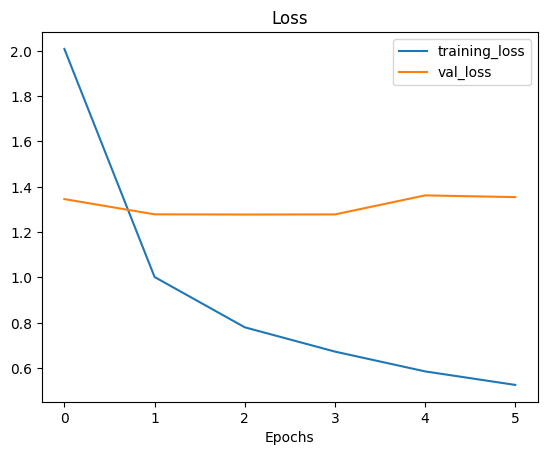

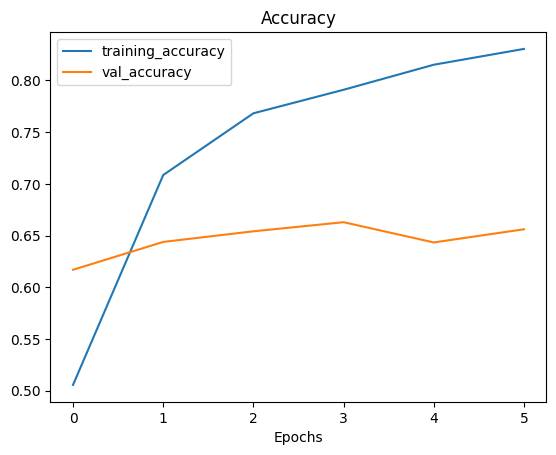

In [29]:
plot_loss_curves(resnet_history)

In [30]:
# I use a function to load in an image that can be used for the model.

def load_and_prep_image(filename, img_shape=224, scale=True):

  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  img = tf.expand_dims(img, axis=0)
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [31]:
test_img = load_and_prep_image("/content/kaggle_data/test/000621fb3cbb32d8935728e48679680e.jpg")

In [32]:
test_img

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.3776162 , 0.42136902, 0.23247127],
         [0.42263502, 0.43121797, 0.30219978],
         [0.4243652 , 0.4043739 , 0.32587957],
         ...,
         [0.41418427, 0.45961815, 0.04105169],
         [0.38782296, 0.43096927, 0.05116857],
         [0.29089814, 0.33600494, 0.02391214]],

        [[0.3571668 , 0.398317  , 0.17044163],
         [0.442245  , 0.4547061 , 0.28141788],
         [0.34614813, 0.32931158, 0.20597473],
         ...,
         [0.3761724 , 0.43387386, 0.03479134],
         [0.31797007, 0.37784785, 0.00466392],
         [0.27890515, 0.3361576 , 0.00351262]],

        [[0.34844202, 0.38373613, 0.1242089 ],
         [0.33515498, 0.35067496, 0.1341957 ],
         [0.30900985, 0.29686856, 0.12998323],
         ...,
         [0.27507818, 0.34736478, 0.00150609],
         [0.4379306 , 0.5134945 , 0.11569422],
         [0.36117697, 0.43832156, 0.01025089]],

        ...,

        [[0.1535425 , 0.21791627, 

In [92]:
pred_resnet_test_img = resnet_model.predict(test_img)

1/1 [==============================] - 0s 28ms/step


In [93]:
pred_resnet_test_img

array([[6.49525930e-07, 1.70849162e-07, 1.04596388e-07, 7.19339519e-11,
        2.09618725e-10, 1.79851356e-09, 5.59404008e-08, 2.95882790e-10,
        1.47856563e-08, 1.45719818e-08, 8.64217309e-11, 3.69475615e-08,
        5.58491690e-11, 2.69675977e-03, 8.59869154e-09, 4.88597651e-09,
        1.01360398e-09, 2.57134973e-11, 1.00874097e-07, 2.09694619e-07,
        1.24393775e-08, 6.24480663e-08, 2.77687536e-06, 3.18198090e-07,
        7.18366744e-09, 1.17644952e-07, 2.10923079e-09, 3.22515799e-11,
        5.83217652e-09, 2.60501588e-06, 8.23891568e-08, 7.53000151e-08,
        1.97121039e-07, 2.31609519e-07, 6.33888081e-11, 7.36816546e-08,
        1.07754450e-09, 1.96050606e-10, 1.35322091e-08, 2.99270786e-09,
        9.66076925e-08, 1.93811012e-09, 3.78126572e-07, 7.79169729e-10,
        1.85031457e-08, 1.51481942e-07, 6.42504050e-10, 4.79242424e-09,
        4.73890094e-10, 6.67630431e-08, 5.97231642e-09, 9.95770133e-09,
        6.94436366e-08, 7.32004546e-09, 9.59525098e-11, 4.586493

In [94]:
pred_resnet_test_img.shape

(1, 120)

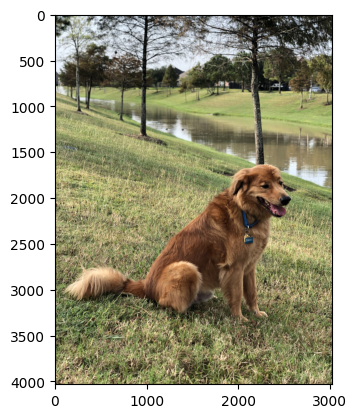

In [156]:
rory_img = load_and_prep_image("/content/IMG-5418.jpg")
img = mpimg.imread("/content/IMG-5418.jpg")
imgplot = plt.imshow(img)
plt.show()

In [36]:
rory_pred = resnet_model.predict(rory_img)

1/1 [==============================] - 0s 25ms/step


In [41]:
rory_pred

array([[1.1513038e-10, 4.6463924e-08, 4.4286530e-10, 1.9219542e-06,
        7.7766174e-07, 3.3156542e-07, 5.1743504e-05, 1.1372964e-06,
        5.1184583e-07, 5.6812400e-08, 4.3736276e-10, 6.2381372e-07,
        1.2314281e-07, 1.2049331e-05, 4.7884433e-04, 1.2914495e-06,
        1.2246780e-10, 1.7373251e-06, 3.2583664e-10, 1.4143577e-09,
        1.0921579e-09, 4.0682011e-07, 2.1025984e-04, 2.2138684e-07,
        1.3512403e-06, 5.1264655e-05, 4.5525380e-07, 1.2867318e-05,
        7.4956633e-02, 5.3738472e-07, 4.8447814e-04, 1.9978778e-08,
        2.7483719e-04, 1.1289566e-05, 1.8205951e-04, 4.7639464e-06,
        3.8813925e-04, 8.1825507e-05, 2.1517662e-08, 3.4817851e-05,
        3.9780584e-06, 2.5961204e-11, 2.3009021e-09, 1.4861488e-06,
        1.1773279e-06, 1.8002845e-07, 5.8014366e-06, 1.5385821e-07,
        5.5582432e-09, 8.8754797e-01, 8.1845974e-10, 6.0723600e-08,
        2.6928379e-07, 1.7731769e-05, 1.5079341e-07, 9.3375760e-09,
        2.6964603e-04, 2.4624571e-04, 7.7287631e

In [157]:
rory_pred.shape

(1, 120)

In [38]:
INDX = (-rory_pred).argsort()
INDX

array([[ 49,  28,  69,  89, 108, 112,  67,  90,  30,  14,  83,  36,  32,
         56,  57,  22,  34,  81,  37,   6,  25,  78,  92,  39,  63,  79,
         87,  53, 107,  27,  13,  33,  46, 110, 113,  35,  93,  40, 101,
         86,   3, 104,  17,  43,  24,  15,  44,   7,  76,  99,  68,   4,
         11,  72,  29,   8,  66, 102,  26,  70,  21,  75,   5, 118,  94,
         52,  85,  23,  59,  45,  47,  54,  12,  60,  58, 111,  51,   9,
        100,   1, 115,  97, 103,  38,  80,  71,  74,  31, 109, 106, 119,
         55, 117,  61, 105,  48,  91,  64,  42,  73,  88,  19,  20,  50,
         65,  82,   2,  10,  18,  95, 114,  84,  16,   0,  96, 116,  77,
         41,  98,  62]])

In [50]:
train_data.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [52]:
class_list = train_data.class_indices.keys()
class_list

dict_keys(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terri

In [43]:
for top_breed in range(5):
    top_idx = (-rory_pred).argsort()
    idx = top_idx[0][top_breed]
    breed = list(train_data.class_indices.keys())[list(train_data.class_indices.values()).index(idx)]
    prob = rory_pred[0][top_idx[0][top_breed]]
    print(breed)
    print(prob)

golden_retriever
0.88754797
chesapeake_bay_retriever
0.07495663
leonberg
0.02060716
redbone
0.006673323
tibetan_mastiff
0.0026389062


In [140]:
# Tests on other dogs.
"""
newdog_img = load_and_prep_image("/content/IMG-4070.jpg")
newdog_pred = resnet_model.predict(newdog_img)
for top_breed in range(5):
    top_idx = (-newdog_pred).argsort()
    idx = top_idx[0][top_breed]
    breed = list(train_data.class_indices.keys())[list(train_data.class_indices.values()).index(idx)]
    prob = newdog_pred[0][top_idx[0][top_breed]]
    print(breed)
    print(prob)
#print(list(train_data.class_indices.keys())[list(train_data.class_indices.values()).index(np.argmax(rory_pred))])
"""

1/1 [==============================] - 0s 28ms/step
pomeranian
0.53496855
chow
0.46490672
pekinese
4.6854762e-05
shetland_sheepdog
3.9214978e-05
collie
3.3587352e-05


In [53]:
from keras.utils import image_dataset_from_directory

In [54]:
# I load the test data to plug into my model.
test_data = image_dataset_from_directory(directory = "/content/kaggle_data/test/",
                                         labels=None,
                                         label_mode = None,
                                         image_size=IMAGE_SHAPE,
                                         batch_size=BATCH_SIZE,
                                         shuffle = False)

Found 10357 files belonging to 1 classes.


In [55]:
# The test data needs to be rescaled, so I normalize it before sending it to the model.
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_test_data = test_data.map(lambda x: (normalization_layer(x)))

In [56]:
normalized_test_data

<_MapDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [95]:
pred_resnet = resnet_model.predict(normalized_test_data)

324/324 [==============================] - 13s 40ms/step


In [96]:
pred_resnet.shape

(10357, 120)

In [97]:
pred_resnet[0]

array([6.4952195e-07, 1.7084992e-07, 1.0459725e-07, 7.1933993e-11,
       2.0962006e-10, 1.7985009e-09, 5.5940117e-08, 2.9588354e-10,
       1.4785722e-08, 1.4571881e-08, 8.6420787e-11, 3.6947796e-08,
       5.5849311e-11, 2.6967733e-03, 8.5987297e-09, 4.8859707e-09,
       1.0136085e-09, 2.5713464e-11, 1.0087358e-07, 2.0969594e-07,
       1.2439338e-08, 6.2448343e-08, 2.7768588e-06, 3.1819707e-07,
       7.1836443e-09, 1.1764538e-07, 2.1092239e-09, 3.2251663e-11,
       5.8322027e-09, 2.6050225e-06, 8.2389057e-08, 7.5300356e-08,
       1.9712137e-07, 2.3160943e-07, 6.3388850e-11, 7.3681846e-08,
       1.0775431e-09, 1.9605112e-10, 1.3532218e-08, 2.9927156e-09,
       9.6607579e-08, 1.9381263e-09, 3.7812754e-07, 7.7916579e-10,
       1.8503298e-08, 1.5148161e-07, 6.4250322e-10, 4.7924726e-09,
       4.7388954e-10, 6.6762823e-08, 5.9723084e-09, 9.9577644e-09,
       6.9443814e-08, 7.3200366e-09, 9.5952933e-11, 4.5865054e-09,
       7.3236911e-10, 3.8163694e-09, 6.2446964e-10, 5.1518356e

In [98]:
np.argmax(pred_resnet[0])

61

In [99]:
(-pred_resnet[0]).argsort()

array([ 61,  85,  13, 100,  84,  70, 110,  22,  29, 109,  87,   0,  93,
        73,  42,  97,  23, 111,  33, 119,  19,  32,   1,  45, 118,  88,
        78,  25,   2,  18,  40, 101,  99,  30,  31,  35,  52,  49,  83,
        21,   6,  11,  92,  74,  76, 106,  71,  44,  65,   8,   9, 112,
        38,  20,  79, 105,  51,  98,  14,  53,  24,  50,  28,  75,  62,
        15,  82,  47,  55,  57, 108,  80,  39, 102, 107,  66,  26,  41,
        94,   5,  77,  64, 114,  67,  36, 113,  90,  16,  81,  95,  69,
       104,  43,  56,  46,  89,  58, 103,  48,  91, 116,   7,  96,  72,
         4,  37, 117,  54,  68,  60,  10,   3,  86,  34, 115,  12,  59,
        27,  17,  63])

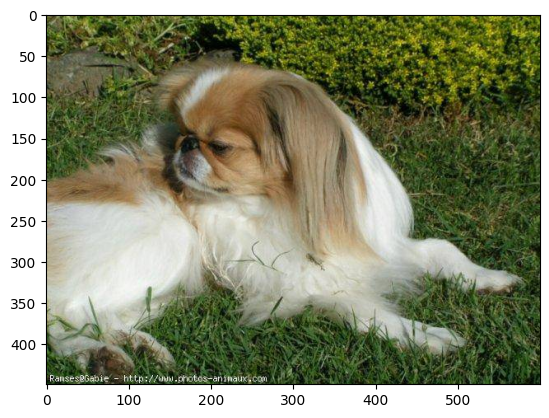

japanese_spaniel: 0.9063019156455994
pekinese: 0.08941808342933655
blenheim_spaniel: 0.0026967732701450586




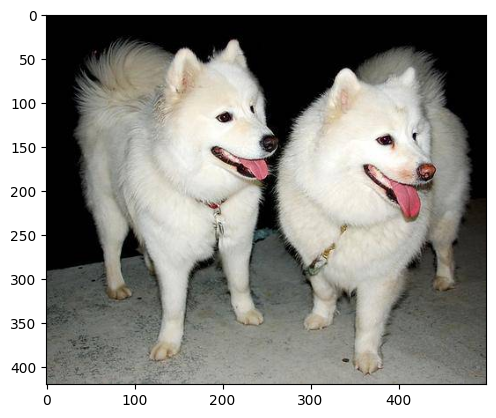

samoyed: 0.9839034080505371
malamute: 0.007112440653145313
pomeranian: 0.0035318469163030386




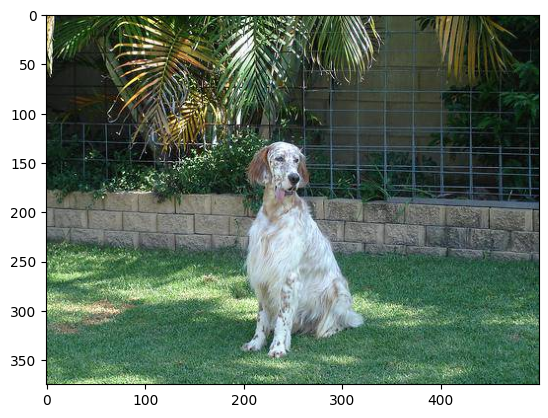

english_setter: 0.5982862114906311
great_pyrenees: 0.3234111964702606
clumber: 0.06321386247873306




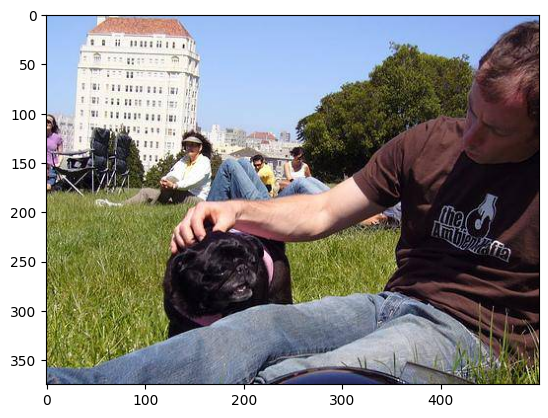

newfoundland: 0.7607476711273193
bluetick: 0.05279648303985596
briard: 0.03523221239447594




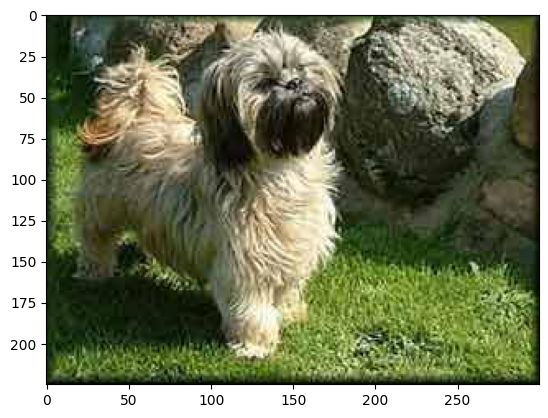

lhasa: 0.8856207728385925
tibetan_terrier: 0.062139227986335754
briard: 0.036802541464567184




In [101]:
sample_images = ["/content/kaggle_data/test/000621fb3cbb32d8935728e48679680e.jpg", "/content/kaggle_data/test/00102ee9d8eb90812350685311fe5890.jpg", "/content/kaggle_data/test/0012a730dfa437f5f3613fb75efcd4ce.jpg", "/content/kaggle_data/test/001510bc8570bbeee98c8d80c8a95ec1.jpg", "/content/kaggle_data/test/001a5f3114548acdefa3d4da05474c2e.jpg"]

for dog in range(len(sample_images)):
    dog_img = pred_resnet[dog]
    img = mpimg.imread(sample_images[dog])
    imgplot = plt.imshow(img)
    plt.show()
    for top_breed in range(3):
        top_idx = (-dog_img).argsort()
        idx = top_idx[top_breed]
        breed = list(train_data.class_indices.keys())[list(train_data.class_indices.values()).index(idx)]
        prob = dog_img[top_idx[top_breed]]
        print(f"{breed}: {prob}")
    print("\n")

In [87]:
# I look at the sample submission file for Kaggle.
sample_data = pd.read_csv("/content/kaggle_data/sample_submission.csv")

In [88]:
sample_data

id  affenpinscher  afghan_hound  \
0      000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1      00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2      0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3      001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4      001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   
...                                 ...            ...           ...   
10352  ffeda8623d4eee33c6d1156a2ecbfcf8       0.008333      0.008333   
10353  fff1ec9e6e413275984966f745a313b0       0.008333      0.008333   
10354  fff74b59b758bbbf13a5793182a9bbe4       0.008333      0.008333   
10355  fff7d50d848e8014ac1e9172dc6762a3       0.008333      0.008333   
10356  fffbff22c1f51e3dc80c4bf04089545b       0.008333      0.008333   

       african_hunting_dog  airedale  american_staffordshire_terrier  \
0                 0.008333  0.008333                        0.008333   
1                 0.008333  0.008333                        0.008333   
2                 0.008333  0.008333                        0.008333   
3                 0.008333  0.008333                        0.008333   
4                 0.008333  0.008333                        0.008333   
...                    ...       ...                             ...   
10352             0.008333  0.008333                        0.008333   
10353             0.008333  0.008333                        0.008333   
10354             0.008333  0.008333                        0.008333   
10355             0.008333  0.008333                        0.008333   
10356             0.008333  0.008333                        0.008333   

       appenzeller  australian_terrier   basenji    basset  ...  toy_poodle  \
0         0.008333            0.008333  0.008333  0.008333  ...    0.008333   
1         0.008333            0.008333  0.008333  0.008333  ...    0.008333   
2         0.008333            0.008333  0.008333  0.008333  ...    0.008333   
3         0.008333            0.008333  0.008333  0.008333  ...    0.008333   
4         0.008333            0.008333  0.008333  0.008333  ...    0.008333   
...            ...                 ...       ...       ...  ...         ...   
10352     0.008333            0.008333  0.008333  0.008333  ...    0.008333   
10353     0.008333            0.008333  0.008333  0.008333  ...    0.008333   
10354     0.008333            0.008333  0.008333  0.008333  ...    0.008333   
10355     0.008333            0.008333  0.008333  0.008333  ...    0.008333   
10356     0.008333            0.008333  0.008333  0.008333  ...    0.008333   

       toy_terrier    vizsla  walker_hound  weimaraner  \
0         0.008333  0.008333      0.008333    0.008333   
1         0.008333  0.008333      0.008333    0.008333   
2         0.008333  0.008333      0.008333    0.008333   
3         0.008333  0.008333      0.008333    0.008333   
4         0.008333  0.008333      0.008333    0.008333   
...            ...       ...           ...         ...   
10352     0.008333  0.008333      0.008333    0.008333   
10353     0.008333  0.008333      0.008333    0.008333   
10354     0.008333  0.008333      0.008333    0.008333   
10355     0.008333  0.008333      0.008333    0.008333   
10356     0.008333  0.008333      0.008333    0.008333   

       welsh_springer_spaniel  west_highland_white_terrier   whippet  \
0                    0.008333                     0.008333  0.008333   
1                    0.008333                     0.008333  0.008333   
2                    0.008333                     0.008333  0.008333   
3                    0.008333                     0.008333  0.008333   
4                    0.008333                     0.008333  0.008333   
...                       ...                          ...       ...   
10352                0.008333                     0.008333  0.008333   
10353                0.008333                     0.008333  0.008333   
10354        

In [102]:
df_resnet = sample_data

In [103]:
# I plug in my model predictions into the submission file.
df_resnet[list(class_list)] = pred_resnet

In [104]:
df_resnet

id  affenpinscher  afghan_hound  \
0      000621fb3cbb32d8935728e48679680e   6.495220e-07  1.708499e-07   
1      00102ee9d8eb90812350685311fe5890   1.822337e-09  4.796231e-09   
2      0012a730dfa437f5f3613fb75efcd4ce   9.894888e-11  4.689074e-04   
3      001510bc8570bbeee98c8d80c8a95ec1   1.484555e-04  1.326297e-04   
4      001a5f3114548acdefa3d4da05474c2e   2.598041e-04  5.923725e-05   
...                                 ...            ...           ...   
10352  ffeda8623d4eee33c6d1156a2ecbfcf8   8.743545e-09  2.811325e-03   
10353  fff1ec9e6e413275984966f745a313b0   1.114352e-10  7.492779e-09   
10354  fff74b59b758bbbf13a5793182a9bbe4   6.812273e-09  8.788221e-09   
10355  fff7d50d848e8014ac1e9172dc6762a3   6.560115e-07  3.669642e-08   
10356  fffbff22c1f51e3dc80c4bf04089545b   2.825181e-11  3.260038e-04   

       african_hunting_dog      airedale  american_staffordshire_terrier  \
0             1.045972e-07  7.193399e-11                    2.096201e-10   
1             5.320244e-10  7.014239e-09                    1.018820e-07   
2             5.187157e-08  9.643001e-08                    3.913306e-08   
3             7.758469e-08  2.135829e-06                    6.629100e-06   
4             3.438504e-07  6.257583e-09                    1.080851e-10   
...                    ...           ...                             ...   
10352         1.126178e-08  7.342171e-06                    4.801730e-07   
10353         6.993238e-12  1.851921e-07                    8.476165e-04   
10354         1.887129e-07  4.379564e-10                    3.176353e-08   
10355         2.294808e-09  3.110151e-09                    2.192802e-12   
10356         7.176698e-10  1.455590e-09                    3.323467e-10   

        appenzeller  australian_terrier       basenji        basset  ...  \
0      1.798501e-09        5.594012e-08  2.958835e-10  1.478572e-08  ...   
1      1.149741e-06        1.105017e-08  5.133400e-09  1.131699e-09  ...   
2      4.378665e-09        1.886171e-08  2.057141e-10  6.559486e-07  ...   
3      5.661856e-03        5.151996e-08  3.447775e-06  1.495693e-05  ...   
4      5.485087e-08        4.697572e-06  7.089208e-11  3.754536e-08  ...   
...             ...                 ...           ...           ...  ...   
10352  5.537829e-06        3.615579e-08  4.220170e-07  2.274926e-08  ...   
10353  2.049697e-06        4.121606e-10  9.474620e-06  9.444562e-06  ...   
10354  1.319271e-07        5.955778e-07  9.418653e-05  5.138617e-08  ...   
10355  1.682915e-09        1.492383e-07  1.551629e-12  4.031159e-08  ...   
10356  7.757000e-11        2.519809e-11  1.097930e-09  1.137673e-11  ...   

         toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0      3.329641e-06  2.326785e-07  1.405331e-08  1.061078e-09  1.230947e-09   
1      1.799414e-05  1.885012e-07  4.596737e-08  2.983304e-07  1.463739e-06   
2      4.665889e-08  9.150090e-07  2.105875e-08  4.030477e-06  1.603863e-04   
3      3.531355e-06  2.497542e-06  3.457886e-05  2.482843e-05  3.718609e-06   
4      1.866747e-07  1.509393e-08  2.555140e-09  4.550196e-11  2.541676e-09   
...             ...           ...           ...           ...           ...   
10352  1.000031e-04  1.311700e-05  7.349169e-08  1.553937e-06  8.075356e-06   
10353  1.023360e-08  3.392717e-09  2.062210e-04  1.136964e-06  9.937025e-01   
10354  5.787605e-08  1.247774e-07  1.327208e-06  3.226861e-07  3.509397e-08   
10355  4.858197e-07  4.697159e-09  2.790107e-09  2.028384e-10  3.784516e-09   
10356  1.421471e-11  5.021661e-10  4.681823e-12  1.457477e-08  2.778032e-10   

       welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0                6.178348e-11                 3.150343e-10  1.428375e-10   
1                1.099559e-09                 1.003793e-05  3.781027e-09   
2                3.331521e-05                 2.018774e-05  1.358267e-06   
3                2.952735e-07                 8.874061e-07  2.325907e-05   
4                

In [ ]:
# I export the submission file into csv format.
# df_resnet.to_csv("/content/" + "submission_resnet.csv", index=False)

In [105]:
# I make my next model - Efficient Net.
effnet_model = create_model(efficientnet_url, num_classes= len(train_data.class_indices))


effnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [106]:
effnet_history = effnet_model.fit(train_data,
                                  epochs=100,
                                  steps_per_epoch=len(train_data),
                                  validation_data=validation_data,
                                  validation_steps=len(validation_data),
                                  callbacks = [early_stoppage],
                                  )


Epoch 1/100
256/256 [==============================] - 138s 508ms/step - loss: 2.0271 - accuracy: 0.5829 - val_loss: 1.0791 - val_accuracy: 0.7280
Epoch 2/100
256/256 [==============================] - 128s 499ms/step - loss: 0.8166 - accuracy: 0.7946 - val_loss: 0.8567 - val_accuracy: 0.7622
Epoch 3/100
256/256 [==============================] - 132s 514ms/step - loss: 0.6132 - accuracy: 0.8358 - val_loss: 0.7939 - val_accuracy: 0.7725
Epoch 4/100
256/256 [==============================] - 134s 522ms/step - loss: 0.5200 - accuracy: 0.8622 - val_loss: 0.7621 - val_accuracy: 0.7701
Epoch 5/100
256/256 [==============================] - 135s 527ms/step - loss: 0.4436 - accuracy: 0.8807 - val_loss: 0.7511 - val_accuracy: 0.7666
Epoch 6/100
256/256 [==============================] - 132s 516ms/step - loss: 0.3953 - accuracy: 0.8923 - val_loss: 0.7466 - val_accuracy: 0.7750
Epoch 7/100
256/256 [==============================] - 141s 550ms/step - loss: 0.3522 - accuracy: 0.9054 - val_loss: 0

The results looks much better on the validation data for Efficient Net! 76% versus 66% on Resnet!

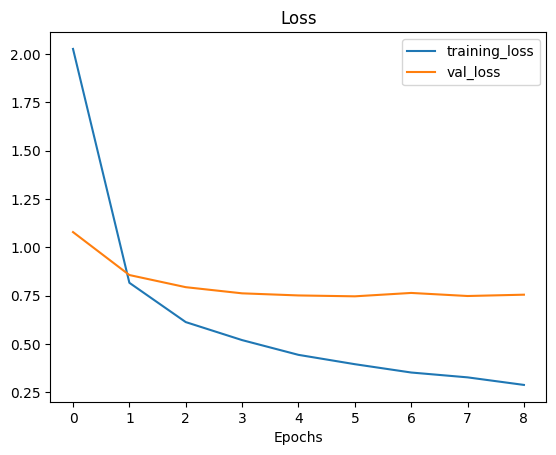

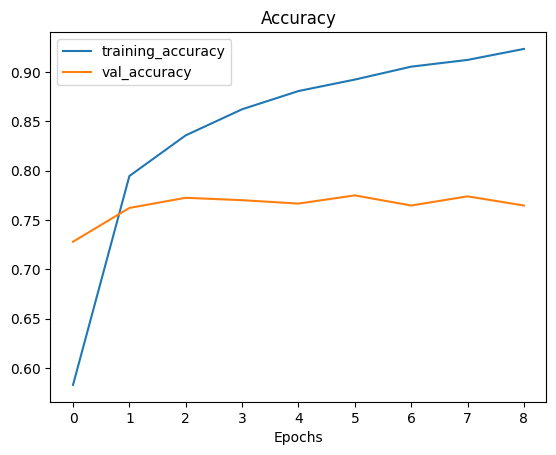

In [107]:
plot_loss_curves(effnet_history)

In [108]:
pred_effnet = effnet_model.predict(normalized_test_data)

324/324 [==============================] - 12s 34ms/step


In [109]:
df_effnet = sample_data
df_effnet[list(class_list)] = pred_effnet
#df_effnet.to_csv("/content/" + "submission_effnet.csv", index=False)

I have tried Resnet and Efficient Net. Now, I will try 2 even more modern models that are ViT models.

In [110]:
# vit_l16_classification Vision Transformer (ViT) fine-tuned on ImageNet-1k.
vit_l16_url = "https://tfhub.dev/sayakpaul/vit_l16_classification/1"

# vit_b8_classification Vision Transformer (ViT) fine-tuned on ImageNet-1k.
vit_b8_url = "https://tfhub.dev/sayakpaul/vit_b8_classification/1"

In [111]:

vit_l16_model = create_model(vit_l16_url, num_classes= len(train_data.class_indices))


vit_l16_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [112]:
vit_l16_model_history = vit_l16_model.fit(train_data,
                                  epochs=100,
                                  steps_per_epoch=len(train_data),
                                  validation_data=validation_data,
                                  validation_steps=len(validation_data),
                                  callbacks = [early_stoppage],
                                  )

Epoch 1/100
256/256 [==============================] - 190s 681ms/step - loss: 1.3537 - accuracy: 0.7178 - val_loss: 0.6278 - val_accuracy: 0.8361
Epoch 2/100
256/256 [==============================] - 150s 583ms/step - loss: 0.5169 - accuracy: 0.8546 - val_loss: 0.5488 - val_accuracy: 0.8386
Epoch 3/100
256/256 [==============================] - 150s 585ms/step - loss: 0.4498 - accuracy: 0.8726 - val_loss: 0.5433 - val_accuracy: 0.8474
Epoch 4/100
256/256 [==============================] - 151s 591ms/step - loss: 0.4036 - accuracy: 0.8772 - val_loss: 0.5831 - val_accuracy: 0.8371
Epoch 5/100
256/256 [==============================] - 153s 596ms/step - loss: 0.3662 - accuracy: 0.8909 - val_loss: 0.5593 - val_accuracy: 0.8371
Epoch 6/100
256/256 [==============================] - 161s 627ms/step - loss: 0.3406 - accuracy: 0.8934 - val_loss: 0.5624 - val_accuracy: 0.8459


Wow! The ViT model performs even better than the Effnet model by about 8% on the test data!

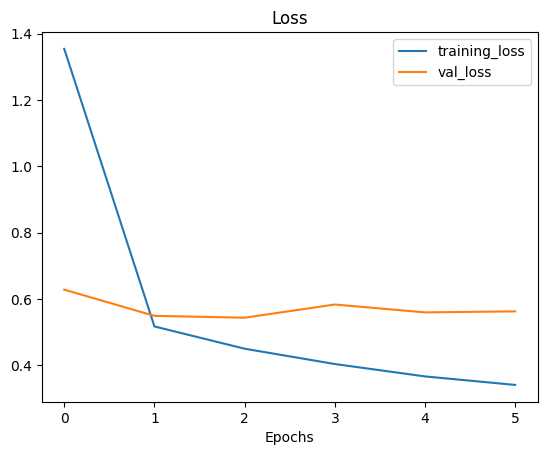

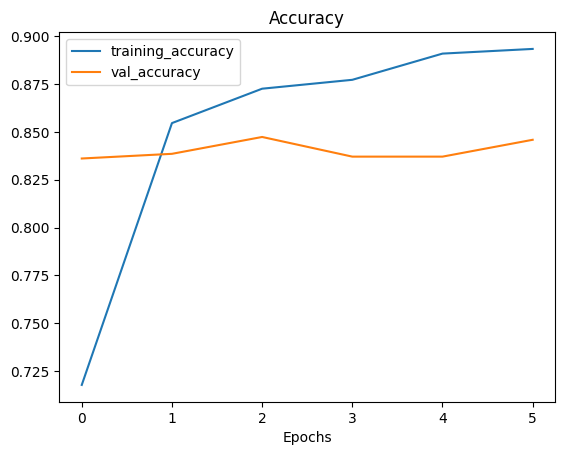

In [142]:
plot_loss_curves(vit_l16_model_history)

In [136]:
pred_vit_l16 = vit_l16_model.predict(normalized_test_data)

324/324 [==============================] - 135s 388ms/step


In [137]:
df_vit_l16 = sample_data
df_vit_l16[list(class_list)] = pred_vit_l16
df_vit_l16.to_csv("/content/" + "submission_vit_l16.csv", index=False)

In [138]:

vit_b8_model = create_model(vit_b8_url, num_classes= len(train_data.class_indices))


vit_b8_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [139]:
vit_b8_model_history = vit_b8_model.fit(train_data,
                                  epochs=100,
                                  steps_per_epoch=len(train_data),
                                  validation_data=validation_data,
                                  validation_steps=len(validation_data),
                                  callbacks = [early_stoppage],
                                  )

Epoch 1/100
256/256 [==============================] - 200s 735ms/step - loss: 1.2832 - accuracy: 0.6866 - val_loss: 0.7004 - val_accuracy: 0.7935
Epoch 2/100
256/256 [==============================] - 168s 657ms/step - loss: 0.5859 - accuracy: 0.8217 - val_loss: 0.6762 - val_accuracy: 0.8033
Epoch 3/100
256/256 [==============================] - 166s 646ms/step - loss: 0.5072 - accuracy: 0.8494 - val_loss: 0.6114 - val_accuracy: 0.8195
Epoch 4/100
256/256 [==============================] - 167s 650ms/step - loss: 0.4465 - accuracy: 0.8607 - val_loss: 0.7341 - val_accuracy: 0.7960
Epoch 5/100
256/256 [==============================] - 166s 649ms/step - loss: 0.4387 - accuracy: 0.8604 - val_loss: 0.6649 - val_accuracy: 0.8239
Epoch 6/100
256/256 [==============================] - 168s 655ms/step - loss: 0.4160 - accuracy: 0.8711 - val_loss: 0.6451 - val_accuracy: 0.8234


The ViT B8 model doesn't perform as well as the ViT L16 model.

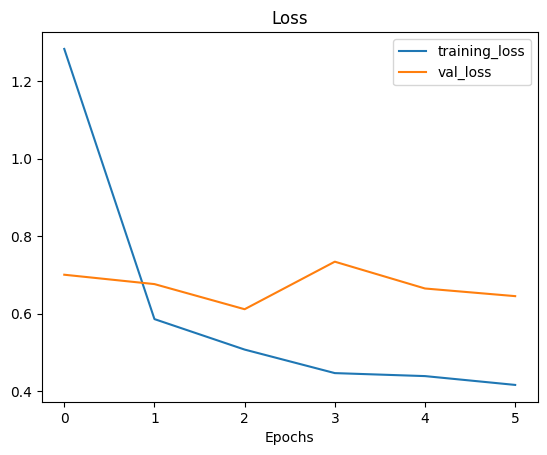

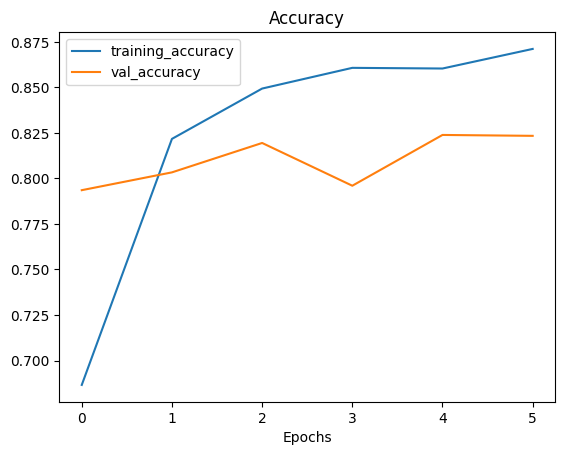

In [145]:
plot_loss_curves(vit_b8_model_history)

In [146]:
pred_vit_b8 = vit_b8_model.predict(normalized_test_data)

324/324 [==============================] - 174s 523ms/step


In [158]:
df_vit_b8 = sample_data
df_vit_b8[list(class_list)] = pred_vit_b8
df_vit_b8.to_csv("/content/" + "submission_vit_b8.csv", index=False)

Since all my models have been augmented until now, I decide to try training my ViT L16 model without any augmenation to see if the results change.

In [143]:

vit_l16_model_noaug = create_model(vit_l16_url, num_classes= len(train_data.class_indices))


vit_l16_model_noaug.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [144]:
vit_l16_noaug_history = vit_l16_model_noaug.fit(train_data_noaug,
                                  epochs=100,
                                  steps_per_epoch=len(train_data_noaug),
                                  validation_data=validation_data_noaug,
                                  validation_steps=len(validation_data_noaug),
                                  callbacks = [early_stoppage],
                                  )

Epoch 1/100
256/256 [==============================] - 196s 718ms/step - loss: 1.3742 - accuracy: 0.7134 - val_loss: 0.6191 - val_accuracy: 0.8288
Epoch 2/100
256/256 [==============================] - 158s 615ms/step - loss: 0.5143 - accuracy: 0.8591 - val_loss: 0.5364 - val_accuracy: 0.8386
Epoch 3/100
256/256 [==============================] - 160s 625ms/step - loss: 0.4442 - accuracy: 0.8722 - val_loss: 0.5758 - val_accuracy: 0.8307
Epoch 4/100
256/256 [==============================] - 160s 624ms/step - loss: 0.3993 - accuracy: 0.8837 - val_loss: 0.5482 - val_accuracy: 0.8410
Epoch 5/100
256/256 [==============================] - 161s 627ms/step - loss: 0.3601 - accuracy: 0.8904 - val_loss: 0.5708 - val_accuracy: 0.8351


In [159]:
pred_vit_l16_noaug = vit_l16_model_noaug.predict(normalized_test_data)
df_vit_l16_noaug = sample_data
df_vit_l16_noaug[list(class_list)] = pred_vit_l16_noaug
df_vit_l16_noaug.to_csv("/content/" + "submission_vit_l16_noaug.csv", index=False)

324/324 [==============================] - 133s 381ms/step


In [148]:
# I re-initiate my ImageDataGenerator, but this time for ALL data since I want to train my final model on ALL data.
train_datagen_alldata = ImageDataGenerator(rescale=1/255.,
                                   #validation_split = 0.2,
                                   rotation_range=10, # rotation
                                   width_shift_range=0.2, # horizontal shift
                                   height_shift_range=0.2, # vertical shift
                                   zoom_range=0.2, # zoom
                                   horizontal_flip=True, # horizontal flip randomly
                                   brightness_range=[0.2,1.2]) # brightness adjustment




train_data_alldata = train_datagen_alldata.flow_from_dataframe(dataframe = df_labels,
                                               directory = train_dir,
                                               x_col = "id",
                                               y_col = "breed",
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical",
                                               #subset = "training"
                                               )

Found 10222 validated image filenames belonging to 120 classes.


In [150]:
# ViT B8 model trained on ALL data.
vit_b8_model_alldata = create_model(vit_b8_url, num_classes= len(train_data_alldata.class_indices))

vit_b8_model_alldata.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [151]:
vit_b8_model_history_alldata = vit_b8_model_alldata.fit(train_data_alldata,
                                  epochs=6,
                                  steps_per_epoch=len(train_data_alldata),
                                  )

Epoch 1/6
320/320 [==============================] - 186s 562ms/step - loss: 1.1745 - accuracy: 0.7036
Epoch 2/6
320/320 [==============================] - 167s 521ms/step - loss: 0.5774 - accuracy: 0.8301
Epoch 3/6
320/320 [==============================] - 169s 526ms/step - loss: 0.5304 - accuracy: 0.8408
Epoch 4/6
320/320 [==============================] - 177s 551ms/step - loss: 0.4874 - accuracy: 0.8561
Epoch 5/6
320/320 [==============================] - 176s 549ms/step - loss: 0.4439 - accuracy: 0.8641
Epoch 6/6
320/320 [==============================] - 173s 541ms/step - loss: 0.4446 - accuracy: 0.8626


In [160]:
pred_vit_b8_alldata = vit_b8_model_alldata.predict(normalized_test_data)
df_vit_b8_model_alldata = sample_data
df_vit_b8_model_alldata[list(class_list)] = pred_vit_b8_alldata
df_vit_b8_model_alldata.to_csv("/content/" + "submission_vit_b8_model_alldata.csv", index=False)

324/324 [==============================] - 170s 510ms/step


In [152]:
# ViT L16 model trained on ALL data.
vit_l16_model_alldata = create_model(vit_l16_url, num_classes= len(train_data_alldata.class_indices))

vit_l16_model_alldata.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [153]:
vit_l16_model_history_alldata = vit_l16_model_alldata.fit(train_data_alldata,
                                  epochs=6,
                                  steps_per_epoch=len(train_data_alldata),
                                  )

Epoch 1/6
320/320 [==============================] - 187s 547ms/step - loss: 1.2233 - accuracy: 0.7352
Epoch 2/6
320/320 [==============================] - 155s 484ms/step - loss: 0.5035 - accuracy: 0.8581
Epoch 3/6
320/320 [==============================] - 155s 485ms/step - loss: 0.4443 - accuracy: 0.8671
Epoch 4/6
320/320 [==============================] - 159s 495ms/step - loss: 0.3955 - accuracy: 0.8824
Epoch 5/6
320/320 [==============================] - 153s 476ms/step - loss: 0.3701 - accuracy: 0.8856
Epoch 6/6
320/320 [==============================] - 159s 497ms/step - loss: 0.3555 - accuracy: 0.8900


In [161]:
pred_vit_l16_alldata = vit_l16_model_alldata.predict(normalized_test_data)
df_vit_l16_model_alldata = sample_data
df_vit_l16_model_alldata[list(class_list)] = pred_vit_l16_alldata
df_vit_l16_model_alldata.to_csv("/content/" + "submission_vit_l16_model_alldata.csv", index=False)

324/324 [==============================] - 134s 380ms/step


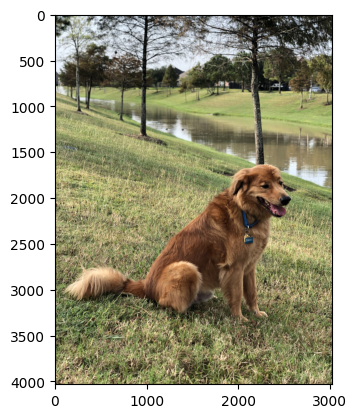

In [164]:
# Checking if Rory's breed outcome has changed with the best performing model.
img = mpimg.imread("/content/IMG-5418.jpg")
imgplot = plt.imshow(img)
plt.show()

In [163]:
rory_pred_vit_l16 = vit_l16_model.predict(rory_img)
for top_breed in range(5):
    top_idx = (-rory_pred_vit_l16).argsort()
    idx = top_idx[0][top_breed]
    breed = list(train_data.class_indices.keys())[list(train_data.class_indices.values()).index(idx)]
    prob = rory_pred_vit_l16[0][top_idx[0][top_breed]]
    print(breed)
    print(prob)

1/1 [==============================] - 0s 28ms/step
golden_retriever
0.99995613
newfoundland
2.0755888e-05
kelpie
1.01773485e-05
chesapeake_bay_retriever
5.91514e-06
labrador_retriever
3.587745e-06


If you recall, on the first model (Resnet) the model gave an 89% probability that Rory is a golden retriever. On my best model (ViT L16), the model gives a 99.9% probability that he is a golden retriever, and it is correct!

In conclusion, the ViT models performed much better than my first two models (Res Net and Efficient Net). To improve results, I can try more different kinds of models, but it will take much time and patience. I was able to see how each model improved its predictability by looking at the results and checking on Google Images if the outcomes made sense. Using a human eye, they were pretty accurate! According to my results on the accuracy data, my ViT L16 augmented data model performed the best. This was in line with my Kaggle submission results, which scored a 0.46957 log loss and scored in the top 50% of submissions.